In [1]:
import tensorflow as tf

import PIL
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sklearn
from sklearn.model_selection import train_test_split

import itertools
from typing import List, Tuple
import copy
import seaborn as sns
import unicodedata
import re
import numpy as np
import os
import io
from skimage.io import imread
import time
from ast import literal_eval
import math
from collections import defaultdict
from statistics import median, mean

from sklearn.metrics import confusion_matrix
import keras
from keras import optimizers
from keras.preprocessing.image import load_img
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation, concatenate, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Parse and Load Dataset

In [2]:
TARGET_SIZE = (640, 360)
IMAGE_EXAMPLE_SHAPE = TARGET_SIZE + (3,)

LANDMARK_EXAMPLE_SHAPE = (39, )

BASE_PATH = '/home/lancecotingkeh/aggregated/'
LABEL_TO_ENCODING = {'proper': 0, 'crooked': 1, 'lockout': 2, 'rounded': 3, 'squat': 4}
ENCODING_TO_LABEL = {v: k for k, v in LABEL_TO_ENCODING.items()}
NUM_CLASSES = len(LABEL_TO_ENCODING)

In [3]:
df_metadata = pd.read_csv('/home/lancecotingkeh/aggregated/pose_landmarks.csv')

In [4]:
df_metadata.head(3)

,relative_image_path,data_split,label,landmark_nose,landmark_left_shoulder,landmark_right_shoulder,landmark_left_elbow,landmark_right_elbow,landmark_left_wrist,landmark_right_wrist,landmark_left_hip,landmark_right_hip,landmark_left_knee,landmark_right_knee,landmark_left_ankle,landmark_right_ankle
0,5_lockout/lyron_deg135_take2/frame46.jpg,train,proper,"(0.8408212661743164, 0.44535547494888306, -0.6...","(0.7523922920227051, 0.483453631401062, -0.080...","(0.59047532081604, 0.4363204836845398, -0.5876...","(0.7419312596321106, 0.6247938871383667, 0.025...","(0.5161336064338684, 0.5835246443748474, -0.57...","(0.7500355839729309, 0.7468990683555603, -0.06...","(0.5082715749740601, 0.7348905205726624, -0.60...","(0.4615359604358673, 0.5611119866371155, 0.148...","(0.34500354528427124, 0.5380272269248962, -0.1...","(0.701583981513977, 0.6245787739753723, -0.039...","(0.5147499442100525, 0.576558530330658, -0.833...","(0.6168646812438965, 0.8138770461082458, 0.163...","(0.4869398772716522, 0.7884341478347778, -0.77..."
1,5_lockout/lyron_deg135_take2/frame203.jpg,train,proper,"(0.8654815554618835, 0.4472369849681854, -0.59...","(0.7866912484169006, 0.5048587322235107, -0.12...","(0.6134108901023865, 0.4505915343761444, -0.55...","(0.7522295713424683, 0.6383607983589172, -0.09...","(0.5366990566253662, 0.5983656644821167, -0.55...","(0.7443258762359619, 0.7658225893974304, -0.16...","(0.5270508527755737, 0.7469443678855896, -0.51...","(0.49029654264450073, 0.565066397190094, 0.141...","(0.3752322196960449, 0.5404682159423828, -0.14...","(0.721193253993988, 0.6225733160972595, 0.0097...","(0.604214072227478, 0.5913941860198975, -0.544...","(0.6175094246864319, 0.7968677282333374, 0.155...","(0.4880143404006958, 0.7921530604362488, -0.41..."
2,5_lockout/lyron_deg135_take2/frame207.jpg,train,proper,"(0.8618521690368652, 0.42703595757484436, -0.5...","(0.7759232521057129, 0.48765045404434204, -0.0...","(0.6108279228210449, 0.43047401309013367, -0.4...","(0.7476211786270142, 0.6245181560516357, 0.032...","(0.526120126247406, 0.5700463652610779, -0.489...","(0.7355574369430542, 0.7427244186401367, -0.06...","(0.5221640467643738, 0.7184542417526245, -0.49...","(0.4879094958305359, 0.5496541261672974, 0.132...","(0.37393078207969666, 0.5203757286071777, -0.1...","(0.7107850313186646, 0.6180444359779358, 0.138...","(0.574447512626648, 0.5620325207710266, -0.697...","(0.5569970607757568, 0.7731618285179138, 0.340...","(0.47665083408355713, 0.7690679430961609, -0.6..."


In [5]:
landmark_columns = [col for col in df_metadata if col.startswith('landmark_')]
landmark_columns

['landmark_nose',
 'landmark_left_shoulder',
 'landmark_right_shoulder',
 'landmark_left_elbow',
 'landmark_right_elbow',
 'landmark_left_wrist',
 'landmark_right_wrist',
 'landmark_left_hip',
 'landmark_right_hip',
 'landmark_left_knee',
 'landmark_right_knee',
 'landmark_left_ankle',
 'landmark_right_ankle']

In [6]:
def load_preprocess_imgs(image_paths: List[str]) -> np.ndarray:
    images = []
    for image_path in image_paths:
        img = load_img(image_path, target_size=TARGET_SIZE)        
        np_img = np.asarray(img)

        assert np_img.shape == IMAGE_EXAMPLE_SHAPE
        
        images.append(np_img)
        
        # horizontal flip both image
        horizontal_flipped_img = img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
        np_img = np.asarray(img)
        images.append(np_img)
        
    return np.array(images)

In [7]:
def load_preprocess_landmarks(df_metadata) -> np.ndarray:
    landmark_examples = []
    
    for row in df_metadata.iterrows():
        single_example = []
        flipped_example = []
        
        for landmark in landmark_columns:
            x, y, z = literal_eval(row[1][landmark])
            
            single_example.extend([x, y, z])
            
            # horizontal flip landmark
            
            flipped_example.extend([1-x, y, z])
        
        landmark_examples.append(np.array(single_example))
        landmark_examples.append(np.array(flipped_example))
    return np.array(landmark_examples)

In [8]:
def interleave_np_arrays(a, b):
    a_shape = a.shape
    c = np.empty((a_shape[0] * 2, a_shape[1]), dtype=a.dtype)
    c[0::2] = a
    c[1::2] = b
    
    return c

In [9]:
# load training data

df_train = df_metadata[df_metadata['data_split'] == 'train']
X_train_imgs = load_preprocess_imgs([f'{BASE_PATH}{p}' for p in df_train['relative_image_path']])
X_train_landmarks = load_preprocess_landmarks(df_train)
Y_train = keras.utils.to_categorical([LABEL_TO_ENCODING[l] for l in df_train['label']], 5)
Y_train = interleave_np_arrays(Y_train, Y_train)

In [10]:
len(df_train), len(X_train_imgs), len(X_train_landmarks), len(Y_train)

(589, 1178, 1178, 1178)

In [11]:
# load validation data
df_val = df_metadata[df_metadata['data_split'] == 'val']
X_val_imgs = load_preprocess_imgs([f'{BASE_PATH}{p}' for p in df_val['relative_image_path']])
X_val_landmarks = load_preprocess_landmarks(df_val)
Y_val = keras.utils.to_categorical([LABEL_TO_ENCODING[l] for l in df_val['label']], 5)
Y_val = interleave_np_arrays(Y_val, Y_val)

In [12]:
len(df_val), len(X_val_imgs), len(X_val_landmarks), len(Y_val)

(100, 200, 200, 200)

In [13]:
# load test data
df_test = df_metadata[df_metadata['data_split'] == 'test']
X_test_imgs = load_preprocess_imgs([f'{BASE_PATH}{p}' for p in df_test['relative_image_path']])
X_test_landmarks = load_preprocess_landmarks(df_test)
Y_test = keras.utils.to_categorical([LABEL_TO_ENCODING[l] for l in df_test['label']], 5)
Y_test = interleave_np_arrays(Y_test, Y_test)

In [14]:
len(df_test), len(X_test_imgs), len(X_test_landmarks), len(Y_test)

(200, 400, 400, 400)

In [15]:
IMAGE_EXAMPLE_SHAPE

(640, 360, 3)

# Define Layers

In [16]:
initializer = tf.initializers.VarianceScaling(scale=2.0)

class ConvGroupLayer(tf.keras.layers.Layer):
    def __init__(self, channel_size: int, filter_size: Tuple[int, int], dropout_rate: float):
        self.conv = Conv2D(channel_size, filter_size, padding='same', kernel_initializer=initializer)
        self.max_pool = MaxPooling2D(filter_size)
        self.bn = BatchNormalization(axis=-1)
        self.relu = LeakyReLU(alpha=0.1)
        self.drop_out = Dropout(dropout_rate)
    
    def __call__(self, x):
        x = self.conv(x)
        x = self.max_pool(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.drop_out(x)
        
        return x

class CNNTower(tf.keras.layers.Layer):
    def __init__(self, num_conv_layers:int, initial_channel_size: int, initial_filter_size: Tuple[int, int], dropout_rate: float):
        self.initial_conv = Conv2D(initial_channel_size, initial_filter_size, padding='same', kernel_initializer=initializer, input_shape=IMAGE_EXAMPLE_SHAPE)
        self.initial_max_pool = MaxPooling2D(initial_filter_size, padding='same')
        self.initial_bn = BatchNormalization(axis=-1)
        self.initial_relu = LeakyReLU(alpha=0.1)
        self.initial_drop_out = Dropout(dropout_rate)
        
        self.intermediate_conv_layers = []
        
        for idx in range(num_conv_layers):
            channel_size = initial_channel_size//(2**(idx+1))
            
            self.intermediate_conv_layers.append(ConvGroupLayer(channel_size, initial_filter_size, dropout_rate))
            
    def __call__(self, x):
        x = self.initial_conv(x)
        x = self.initial_max_pool(x)
        x = self.initial_bn(x)
        x = self.initial_relu(x)
        x = self.initial_drop_out(x)
        
        for layer in self.intermediate_conv_layers:
            x = layer(x)
            
        return Flatten()(x)
            
        
        
        
        

In [17]:
# cnn_tower = CNNTower(num_conv_layers = 3,
#                      initial_channel_size = 128,
#                      initial_filter_size = (3, 3),
#                      dropout_rate = 0.20
#                     )
# cnn_tower(tf.random.uniform((32, 640, 360, 3), dtype=tf.float32, minval=0, maxval=256))

In [18]:
class DNN(tf.keras.layers.Layer):
    def __init__(self, num_layers: int, initial_dense_size: int, dropout_rate: float):
        self.layers = []
        
        for idx in range(num_layers):
            self.layers.append(Dense(initial_dense_size//(2**idx)))
            self.layers.append(tf.keras.layers.BatchNormalization())
            self.layers.append(LeakyReLU(alpha=0.1))
            
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        return x
            
            
    

In [19]:
# dnn = DNN(3, 256, 0.2)
# dnn(tf.random.uniform((32, 488), dtype=tf.float32))

# Two Tower Input Model

In [20]:
NUM_CONV_LAYERS = 3
INITIAL_CHANNEL_SIZE = 128
INITIAL_FILTER_SIZE = (3,3)
DROPOUT_RATE = 0.20

In [21]:
DNN_LAYERS = 3
DENSE_SIZE = 1024

In [22]:
OUTPUT_DENSE_LAYERS = 2
OUTPUT_DENSE_SIZE = 256

In [23]:
# image_input

In [24]:
image_input = Input(shape=IMAGE_EXAMPLE_SHAPE)
cnn_tower = CNNTower(num_conv_layers = NUM_CONV_LAYERS,
                     initial_channel_size = INITIAL_CHANNEL_SIZE,
                     initial_filter_size = INITIAL_FILTER_SIZE,
                     dropout_rate = DROPOUT_RATE
                    )
x_cnn_tower = cnn_tower(image_input)

In [25]:
landmark_input = Input(shape=LANDMARK_EXAMPLE_SHAPE)
dnn_tower = DNN(DNN_LAYERS, DENSE_SIZE, DROPOUT_RATE)

x_dnn_tower = dnn_tower(landmark_input)

In [26]:
x = concatenate([x_cnn_tower, x_dnn_tower])

In [27]:
output_tower = DNN(OUTPUT_DENSE_LAYERS, OUTPUT_DENSE_SIZE, DROPOUT_RATE)
x = output_tower(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

In [28]:
model = Model(inputs=[image_input, landmark_input], outputs=[output])

In [29]:
opt = optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [30]:
# model.summary()

In [31]:
epochs = 100
batch_size = 32

In [32]:
model.fit([X_train_imgs, X_train_landmarks], Y_train,
          batch_size=batch_size,
          epochs=epochs,
#           callbacks=callbacks,
          verbose=1,
          validation_data=([X_val_imgs, X_val_landmarks], Y_val),
          shuffle=True)

Epoch 1/100
37/37 [==============================] - 17s 456ms/step - loss: 0.8599 - accuracy: 0.6630 - val_loss: 8.2902 - val_accuracy: 0.6800
Epoch 2/100
37/37 [==============================] - 16s 427ms/step - loss: 0.4322 - accuracy: 0.8336 - val_loss: 3.4012 - val_accuracy: 0.6800
Epoch 3/100
37/37 [==============================] - 16s 420ms/step - loss: 0.3238 - accuracy: 0.8701 - val_loss: 1.9996 - val_accuracy: 0.7050
Epoch 4/100
37/37 [==============================] - 15s 415ms/step - loss: 0.2875 - accuracy: 0.8862 - val_loss: 1.0081 - val_accuracy: 0.7200
Epoch 5/100
37/37 [==============================] - 15s 413ms/step - loss: 0.2566 - accuracy: 0.8990 - val_loss: 0.7926 - val_accuracy: 0.7400
Epoch 6/100
37/37 [==============================] - 15s 416ms/step - loss: 0.2388 - accuracy: 0.9151 - val_loss: 0.5803 - val_accuracy: 0.8200
Epoch 7/100
37/37 [==============================] - 15s 419ms/step - loss: 0.2136 - accuracy: 0.9143 - val_loss: 0.6296 - val_accuracy:

In [33]:
model.evaluate([X_test_imgs, X_test_landmarks], Y_test, verbose=1)

13/13 [==============================] - 2s 170ms/step - loss: 0.9972 - accuracy: 0.7475


[0.9971678256988525, 0.7475000023841858]

In [34]:
Y_preds = model.predict([X_test_imgs, X_test_landmarks])

In [35]:
Y_test_labels = np.argmax(Y_test, axis=-1)
Y_preds_labels = np.argmax(Y_preds, axis=-1)

In [36]:
print(sklearn.metrics.classification_report(Y_test_labels, Y_preds_labels))

              precision    recall  f1-score   support

           0       0.75      0.92      0.83       266
           1       0.50      0.12      0.20        32
           2       0.79      0.58      0.67        38
           3       0.75      0.38      0.50        32
           4       0.70      0.50      0.58        32

    accuracy                           0.75       400
   macro avg       0.70      0.50      0.56       400
weighted avg       0.73      0.75      0.72       400



In [37]:
def confusion_matrix(y_true: List[int], y_pred: List[int], labels=list(LABEL_TO_ENCODING.keys()), ymap=None, figsize=(10,10)):
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=labels)
    
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    # plt.savefig(filename)

In [38]:
Y_test_labels_str = [ENCODING_TO_LABEL[l] for l in Y_test_labels]
Y_preds_labels_str = [ENCODING_TO_LABEL[l] for l in Y_preds_labels]

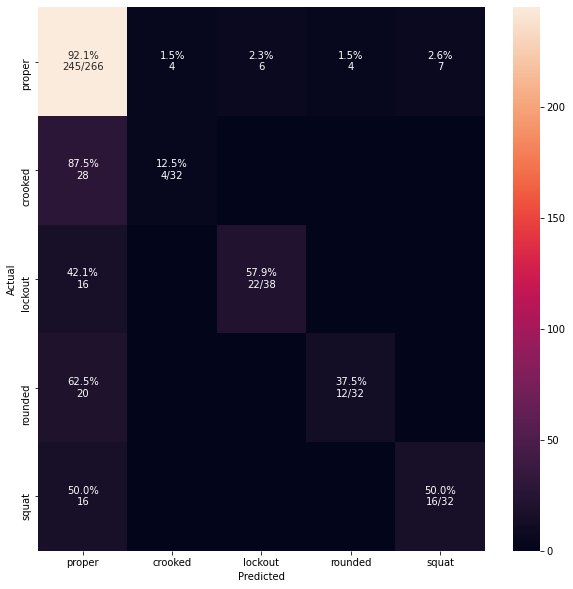

In [39]:
confusion_matrix(Y_test_labels_str, Y_preds_labels_str, list(LABEL_TO_ENCODING.keys()))

# [Ablation] Image only

In [40]:
image_input = Input(shape=IMAGE_EXAMPLE_SHAPE)
cnn_tower = CNNTower(num_conv_layers = NUM_CONV_LAYERS,
                     initial_channel_size = INITIAL_CHANNEL_SIZE,
                     initial_filter_size = INITIAL_FILTER_SIZE,
                     dropout_rate = DROPOUT_RATE
                    )
x_cnn_tower = cnn_tower(image_input)

In [41]:
output_tower = DNN(OUTPUT_DENSE_LAYERS, OUTPUT_DENSE_SIZE, DROPOUT_RATE)
x = output_tower(x_cnn_tower)
output = Dense(NUM_CLASSES, activation='softmax')(x)

In [42]:
ablation_model_image = Model(inputs=[image_input], outputs=[output])

In [43]:
# opt = optimizers.Adam()

ablation_model_image.compile(loss='categorical_crossentropy',
                             optimizer=opt,
                             metrics=['accuracy'])

In [44]:
epochs = 100
batch_size = 32

In [ ]:
ablation_model_image.fit([X_train_imgs], Y_train,
                         batch_size=batch_size,
                         epochs=epochs,
#                          callbacks=callbacks,
                         verbose=1,
                         validation_data=([X_val_imgs], Y_val),
                         shuffle=True)

Epoch 1/100
37/37 [==============================] - 16s 423ms/step - loss: 0.7970 - accuracy: 0.6851 - val_loss: 97.1181 - val_accuracy: 0.6800
Epoch 2/100
37/37 [==============================] - 15s 417ms/step - loss: 0.3728 - accuracy: 0.8319 - val_loss: 7.1931 - val_accuracy: 0.6800
Epoch 3/100
37/37 [==============================] - 15s 417ms/step - loss: 0.3121 - accuracy: 0.8795 - val_loss: 1.7862 - val_accuracy: 0.7000
Epoch 4/100
37/37 [==============================] - 15s 416ms/step - loss: 0.2346 - accuracy: 0.8998 - val_loss: 1.1735 - val_accuracy: 0.8300
Epoch 5/100
37/37 [==============================] - 15s 415ms/step - loss: 0.1793 - accuracy: 0.9346 - val_loss: 0.5469 - val_accuracy: 0.7700
Epoch 6/100
37/37 [==============================] - 15s 415ms/step - loss: 0.1809 - accuracy: 0.9304 - val_loss: 0.3207 - val_accuracy: 0.8700
Epoch 7/100
37/37 [==============================] - 15s 416ms/step - loss: 0.1483 - accuracy: 0.9423 - val_loss: 0.3752 - val_accuracy

In [ ]:
Y_preds = ablation_model_image.predict([X_test_imgs, X_test_landmarks])

In [ ]:
Y_test_labels = np.argmax(Y_test, axis=-1)
Y_preds_labels = np.argmax(Y_preds, axis=-1)

In [ ]:
print(sklearn.metrics.classification_report(Y_test_labels, Y_preds_labels))

# [Ablation] Pose Landmarks Only

In [ ]:
landmark_input = Input(shape=LANDMARK_EXAMPLE_SHAPE)
dnn_tower = DNN(DNN_LAYERS, DENSE_SIZE, DROPOUT_RATE)

x_dnn_tower = dnn_tower(landmark_input)

In [ ]:
output_tower = DNN(OUTPUT_DENSE_LAYERS, OUTPUT_DENSE_SIZE, DROPOUT_RATE)
x = output_tower(x_dnn_tower)
output = Dense(NUM_CLASSES, activation='softmax')(x)

In [ ]:
ablation_model_landmark = Model(inputs=[landmark_input], outputs=[output])

In [ ]:
# opt = optimizers.Adam()

ablation_model_landmark.compile(loss='categorical_crossentropy',
                                optimizer=opt,
                                metrics=['accuracy'])

In [ ]:
epochs = 100
batch_size = 32

In [ ]:
ablation_model_landmark.fit([X_train_landmarks], Y_train,
                            batch_size=batch_size,
                            epochs=epochs,
#                          callbacks=callbacks,
                            verbose=1,
                            validation_data=([X_val_landmarks], Y_val),
                            shuffle=True)

In [ ]:
Y_preds = ablation_model_landmark.predict([X_test_landmarks])

In [ ]:
Y_test_labels = np.argmax(Y_test, axis=-1)
Y_preds_labels = np.argmax(Y_preds, axis=-1)

In [ ]:
print(sklearn.metrics.classification_report(Y_test_labels, Y_preds_labels))